In [1]:
import warnings, os, re, math, smopy, ast, pycrs, collections, dill, pickle, random
import numpy as np
import pandas as pd
import seaborn as sns
#import geopandas as gpd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from numpy.random import randint
from simpledbf import Dbf5
from matplotlib.colors import LogNorm
from statistics import mean
from collections import Counter, defaultdict
from tqdm import tqdm
from copy import deepcopy
from math import pi
from pathlib import Path
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
from sklearn.exceptions import ConvergenceWarning
from sklearn import preprocessing
from sklearn.cluster import KMeans
from scipy import stats
random.seed()
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

filepath = "../data/"
resultpath = "../results/"
logpath = "../logs/"


In [2]:
with open(f'{logpath}kmeans_resubmission.txt','r') as f:
    results = f.read().split('\n')

In [3]:
results

['2 cluster, 2 feature:',
 'MAE(training): 0.5801217943502142',
 'MSE(training): 0.6058578773729656',
 '',
 '',
 '2 cluster, 3 feature:',
 'MAE(training): 0.5729436251926715',
 'MSE(training): 0.589061122152852',
 '',
 '',
 '2 cluster, 4 feature:',
 'MAE(training): 0.5779254255785398',
 'MSE(training): 0.5813360260051227',
 '',
 '',
 '2 cluster, 5 feature:',
 'MAE(training): 0.5725563283053634',
 'MSE(training): 0.5741686200644986',
 '',
 '',
 '2 cluster, 6 feature:',
 'MAE(training): 0.5628030876918747',
 'MSE(training): 0.5500096470515986',
 '',
 '',
 '2 cluster, 7 feature:',
 'MAE(training): 0.5549138372164709',
 'MSE(training): 0.5241280323339814',
 '',
 '',
 '2 cluster, 8 feature:',
 'MAE(training): 0.5524937961944627',
 'MSE(training): 0.513783004335469',
 '',
 '',
 '2 cluster, 9 feature:',
 'MAE(training): 0.5297269182426769',
 'MSE(training): 0.4883154011564713',
 '',
 '',
 '2 cluster, 10 feature:',
 'MAE(training): 0.5152680994452671',
 'MSE(training): 0.4538066782163152',
 ''

In [4]:
mses = defaultdict(dict)
maes = defaultdict(dict)
for i in range(len(results)):
    if 'feature:' in results[i]:
        r = results[i].split(' ')
        k = int(r[0])
        f = int(r[2])
        maes[k][f] = float(results[i+1].split(' ')[1])
        mses[k][f] = float(results[i+2].split(' ')[1])

In [5]:
pd.DataFrame(maes) #Columns = K, rows = F

,2,3,4,5,6,7,8,9,10
2,0.580122,0.564018,0.559115,0.556042,0.539589,0.541632,0.534924,0.525223,0.522465
3,0.572944,0.559658,0.556536,0.541080,0.543706,0.533219,0.522680,0.520942,0.507347
4,0.577925,0.552884,0.540390,0.518694,0.512489,0.506843,0.491539,0.487754,0.480270
5,0.572556,0.526990,0.510714,0.499539,0.488265,0.476119,0.471894,0.453273,0.443912
6,0.562803,0.518629,0.490401,0.484220,0.476111,0.465010,0.456139,0.451491,0.434337
7,0.554914,0.515019,0.488057,0.482339,0.468213,0.447540,0.442197,0.430677,0.404415
8,0.552494,0.492854,0.481610,0.470164,0.444813,0.431835,0.426352,0.392684,0.381632
9,0.529727,0.471048,0.457011,0.444162,0.433761,0.416138,0.393357,0.363067,0.346644
10,0.515268,0.467240,0.451811,0.429381,0.413547,0.393533,0.378107,0.348573,0.323992


In [6]:
pd.DataFrame(mses) #Columns = K, rows = F

,2,3,4,5,6,7,8,9,10
2,0.605858,0.577197,0.569150,0.560642,0.537676,0.544686,0.530702,0.514083,0.507534
3,0.589061,0.562881,0.561096,0.540575,0.529832,0.523796,0.503251,0.502115,0.461343
4,0.581336,0.527861,0.508697,0.490748,0.475548,0.467429,0.441637,0.442467,0.423186
5,0.574169,0.488479,0.468727,0.454878,0.438894,0.426774,0.407114,0.372223,0.376452
6,0.550010,0.483592,0.446840,0.446122,0.430350,0.417149,0.390877,0.399643,0.375835
7,0.524128,0.457191,0.434764,0.425563,0.401243,0.369312,0.329791,0.336187,0.290134
8,0.513783,0.424072,0.424221,0.398510,0.361250,0.338226,0.324955,0.279221,0.273058
9,0.488315,0.378225,0.379169,0.363265,0.343967,0.303139,0.293017,0.231743,0.219079
10,0.453807,0.402156,0.379626,0.321250,0.300360,0.280990,0.276429,0.241192,0.200100


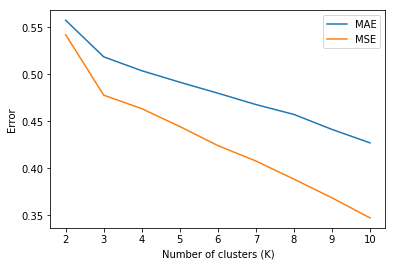

In [7]:
ma, = plt.plot(pd.DataFrame(maes).mean(axis=0),label='MAE')
ms, = plt.plot(pd.DataFrame(mses).mean(axis=0),label='MSE')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Error')
plt.legend(handles=[ma,ms])
plt.savefig(f'{resultpath}kmeans/maemsek.png',dpi=300)

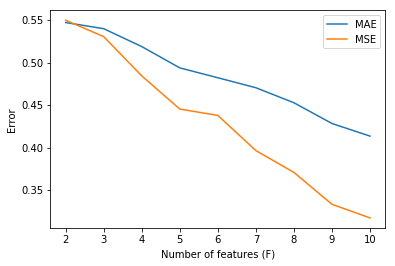

In [8]:
ma, = plt.plot(pd.DataFrame(maes).mean(axis=1),label='MAE')
ms, = plt.plot(pd.DataFrame(mses).mean(axis=1),label='MSE')
plt.xlabel('Number of features (F)')
plt.ylabel('Error')
plt.legend(handles=[ma,ms])
plt.savefig(f'{resultpath}kmeans/maemsef.png',dpi=300)

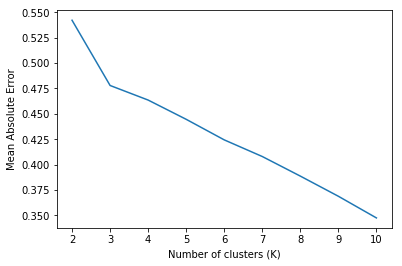

In [9]:
plt.plot(pd.DataFrame(mses).mean(axis=0))
plt.xlabel('Number of clusters (K)')
plt.ylabel('Mean Absolute Error')
plt.savefig(f'{resultpath}kmeans/msek.png',dpi=300)

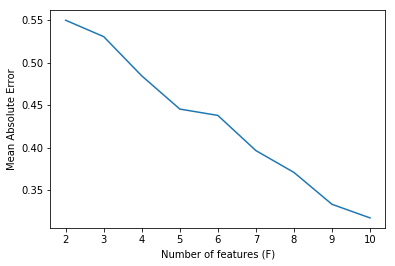

In [10]:
plt.plot(pd.DataFrame(mses).mean(axis=1))
plt.xlabel('Number of features (F)')
plt.ylabel('Mean Absolute Error')
plt.savefig(f'{resultpath}kmeans/msef.png',dpi=300)

In [11]:
silhouettes = defaultdict(dict)
for line in results:
    if 'and' in line:
        l = line.split(' ')
        k = int(l[0])
        f = int(l[3])
        s = float(l[-1])
        silhouettes[k][f] = s

In [12]:
pd.DataFrame(silhouettes)

,2,3,4,5,6,7,8,9,10
2,0.63,0.38,0.15,0.06,-0.51,-0.58,-0.47,-0.39,-0.41
3,0.76,0.33,-0.27,-0.20,-0.16,-0.21,-0.11,-0.26,-0.11
4,0.66,0.36,-0.13,-0.09,-0.09,-0.07,-0.04,-0.18,-0.09
5,0.63,0.36,-0.07,-0.01,0.04,-0.02,-0.01,-0.01,-0.13
6,0.50,0.35,-0.17,0.12,0.15,0.04,0.11,0.08,0.10
7,0.45,0.36,-0.02,0.11,0.14,0.17,0.12,0.11,-0.01
8,0.39,0.29,-0.09,0.03,0.08,0.09,0.11,0.01,0.03
9,0.37,0.30,0.24,-0.03,0.05,0.09,-0.06,0.08,0.10
10,0.35,0.31,-0.00,0.05,0.10,0.04,0.07,0.10,0.16


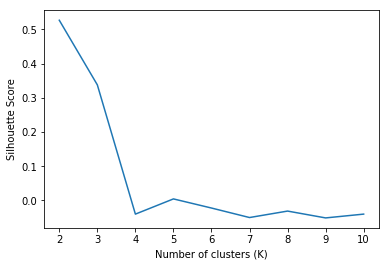

In [13]:
plt.plot(pd.DataFrame(silhouettes).mean(axis=0))
plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouette Score')
plt.savefig(f'{resultpath}kmeans/silk.png',dpi=300)

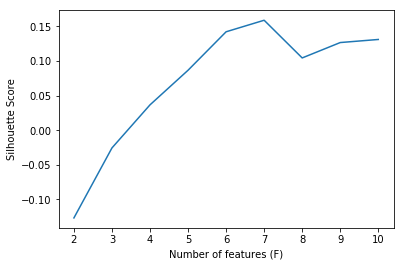

In [14]:
plt.plot(pd.DataFrame(silhouettes).mean(axis=1))
plt.xlabel('Number of features (F)')
plt.ylabel('Silhouette Score')
plt.savefig(f'{resultpath}kmeans/silf.png',dpi=300)

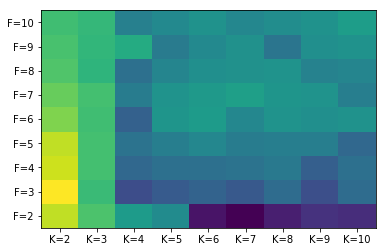

In [15]:
df = pd.DataFrame(silhouettes)
plt.pcolor(df)
plt.yticks(np.arange(0.5, len(df.index), 1), [f'F={t}' for t in df.index])
plt.xticks(np.arange(0.5, len(df.columns), 1), [f'K={t}' for t in df.columns])
plt.savefig(f'{resultpath}kmeans/heatmap.png',dpi=300)

In [16]:
pd.DataFrame(silhouettes)

,2,3,4,5,6,7,8,9,10
2,0.63,0.38,0.15,0.06,-0.51,-0.58,-0.47,-0.39,-0.41
3,0.76,0.33,-0.27,-0.20,-0.16,-0.21,-0.11,-0.26,-0.11
4,0.66,0.36,-0.13,-0.09,-0.09,-0.07,-0.04,-0.18,-0.09
5,0.63,0.36,-0.07,-0.01,0.04,-0.02,-0.01,-0.01,-0.13
6,0.50,0.35,-0.17,0.12,0.15,0.04,0.11,0.08,0.10
7,0.45,0.36,-0.02,0.11,0.14,0.17,0.12,0.11,-0.01
8,0.39,0.29,-0.09,0.03,0.08,0.09,0.11,0.01,0.03
9,0.37,0.30,0.24,-0.03,0.05,0.09,-0.06,0.08,0.10
10,0.35,0.31,-0.00,0.05,0.10,0.04,0.07,0.10,0.16


In [17]:
with open(f'{logpath}/resultsanalysis.dill','wb') as f:
    dill.dump_session(f)